## Projeto: Transformada de Hilbert-Huang

---

#### Por [Beatriz Coimbra](https://github.com/beatrizmcoimbra) e [Fernanda Scovino](https://github.com/fernandascovino)

Implementação da transformada de Hilbert-Huang para identificação de sons e expansão do [verbete na *Wikipédia*](https://pt.wikipedia.org/wiki/Transformada_de_Hilbert-Huang).


### O que é HHT?

A transformada de Hilbert-Huang é uma técnica adaptativa de decomposição de sinais em tempo-frequência. Esta técnica foi desenvolvida num dos organismos da NASA por Northen E. Huang em 1998, e tem sido aplicada a sinais nos mais variados ramos da ciência, que vão desde a engenharia à medicina.<sup>1</sup> 

#### Qual a sua vantagem?

Em relação aos demais métodos para reconhecimento de pitch (frequência fundamental) de um som, como trasformada de Fourier, é que a transformada HHT toma como input dados e não uma função, é um método empírico e não teórico. 

Além disso, os demais métodos assumem que o processo de produção do som é linear e que os sinais são localmente estacionários (variância e média constantes no tempo) - por causa disso, análises com esses métodos só são possíveis em trechos curtos de tempo, logo o som deve ser trabalhando separadamente em diferentes intervalos, o que prejudica a estimação final. Por outro lado, o método empírico da HHT nos permite analisar sinais não-lineares e não-estacionários!<sup>3</sup>

Ela é realizada em duas etapas: **EMD - Método de decomposição do modo empírico, e HSA - Análise espectral de Hilbert**. 

### O que é EMD?

O método de decomposição do modo empírico (EMD) nos permite decompor sinais (para o som, amplitudes no tempo) em um número finito de componentes mais simples, chamados de funções do modo intrínseco (IMF).<sup>3</sup>

#### O que são IMFs?

Uma função de modo intrínseco é definida como qualquer função que tenha os mesmos, ou diferindo no máximo por um, números de zeros (cruzam o eixo x) e extremos, e também ter "envelopes simétricos" definidos pelos máximos e mínimos locais, respectivamente.<sup>1</sup>. Em qualquer, os dados podem envolver mais de um modo oscilatório, por isso que a transformação simples de Hilbert não pode fornecer a descrição completa do conteúdo de frequência para os dados gerais e é necessária a decomposição em IMFs para identificação dos modos<sup>5</sup>.

O processo de geração das IMFs é chamado de *sifting process*, ou "processo de peneiração", que busca suavizar as amplitudes desiguais. A essência do método é identificar os modos oscilatórios intrínsecos a partir das escalas de tempo dos dados empiricamente, e assim decompor os modos<sup>5</sup>.

As splines cúbicas são utilizadas para traçarmos os envelopes, conectando os máximos/mínimos locais.<sup>2</sup> Vale ressaltar que não existe um embasamento teórico para a utilização da spline em relação a outras técnicas de interpolação, um dos motivos pelo qual o EMD é dito empírico. Adaptações já foram feitas, como a utilização de funções radiais para a interpolação<sup>4</sup>, mas a spline continua sendo a mais difundida.

#### Algoritmo

> 1. **Identificação os mínimos e máximos do sinal $x(t)$**
> 2. **Geração dos envelope superior e inferior de $x(t)$**, passando um spline cúbico através dos máximos e mínimos respectivamente
> 3. **Cálculo da média dos envelopes superior e inferior como $m(t)$**
> 4. **Obtenção de um candidato do FMI usando a fórmula  $h_{k}(t) = x(t)−m(t)$**
> 5. **Verificação das propriedades  de uma função do modo intrínseco (IMF) para $h_{k}(t)$**. Se $h_{k}(t)$ não é uma IMF, repetimos o processo a partir do passo 1 com $x(t)=h_{k}(t)$. Se for, obtemos a IMF $c_{k} = h^{*}_{k}$.
> 6. **Cálculo do resíduo $r_{k}(t) = x(t) - c_{k}$ e teste do critério de parada**: $r_{k}(t)$ deve ser monótona. Caso não seja, repetimos o processo tomando $h_{k+1} = r_{k}(t)$

No geral, sendo $h_1(t)$ a 1ª IMF, deve conter o componente de período mais curto do sinal. Como o resíduo contém ainda informação de componentes com período mais longo, refazemos o *sifting* como descrito no passo 5. 

Um critério de parada utilizado para o algoritmo é que o resíduo $r(t)$ se torne uma função monótona.

#### Como identificar uma IMF?

Existem alguns critérios possíveis de serem seguidos, vamos enumerar 2 deles aqui: *Número S* e *Desvio Padrão*. Para fins práticos, utilizaremos o *Desvio Padrão* como critério.

##### Número S

Este critério baseia-se no chamado número S, que é definido como o número de *siftings* consecutivos para os quais o número de zero crossings e extremos são iguais ou no máximo diferentes por um.

O processo só é interrompido se, para S *siftings* consecutivos, os números de cruzamentos nulos e extremos permanecerem iguais e forem iguais ou no máximo diferentes por um.<sup>1</sup>

##### Desvio padrão 

Foi proposto por Huang et al. (1998). Definimos uma soma das diferenças dos *siftings*, ou desvio padrão, como $SD$ da seguinte forma:

$$SD_{k}=\sum_{{t=0}}^{{T}}{\frac  {|h_{1(k-1)}(t)-h_{1k}(t)|^{2}}{h_{1(k-1)}^{2}(t)}}$$ e estabelecemos um limite para seu tamanho, recomendado no intervalo de 0.2 e 0.3 por Huang et al. (1998).


### O que é HSA?

A análise espectral de Hilbert é utilizada para obtermos a frequência instantânea das IMFs. Porém, primeiro devemos filtrar quais IMFs são relevantes para a análise do sinal e quais representam ruídos, o que pode ser avaliado através de do coeficiente de correlação entre cada IMF e $x(t)$.<sup>7</sup>

Na análise, geramos a função complexa $z_{i}(t)$ utilizando $c_{i}(t) = h_{ik}(t)$ como a parte real e a transformação de Hilbert de $c_{i}(t)$ como a parte imaginária, $d(t) = \frac{1}{\pi \int_{-\infty}^{\infty} \frac{c_{i}(t')}{t-t'} dt}$, obtendo:

$$z_i(t) = c_{i}(t) + jd_{i}(t) = a_{i}(t) e^{j \theta_{i}(t)}$$

 sendo $j = \sqrt{-1}$, $a_{i}(t)$ a **amplitude instantânea** e $\theta_{i}(t)$ a **fase instântanea** da IMF $c_{i}(t)$<sup>3</sup>.
 
 A **frequência instantânea** é obtida a partir da derivação da fase instantânea, ou seja, $\omega_{i}(t) = \frac{d\theta_{i}(t)}{dt}$. Logo, podemos representar os sinais $x(t)$ como:
 
 $$ x(t)  = Re \sum_{i=1}^{n} a_{i}(t)e^{j \int \omega_{i}(t) dt}$$
 

### Referências

1: [Hilbert-Huang transform - Wikipédia](https://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform)

2: [Spline - Wikipédia](https://pt.wikipedia.org/wiki/Spline)

3: [Speech pitch determination based on Hilbert-Huang transform - Huang, H.; Pan, J. (2006)](https://www.sciencedirect.com/science/article/pii/S0165168405002367)

4: [Bidimensional Empirical Mode Decomposition Modified for Texture Analysis - Nunes, J.C. et all. (2003)](https://pdfs.semanticscholar.org/4cfd/e80b1f8284e35d7544e84172c95a5d7527fd.pdf)

5: [The empirical mode decomposition and the Hilbert spectrum for nonlinear and non-stationary time series analysis - Huang, N. et all. (1998)](http://rspa.royalsocietypublishing.org/content/454/1971/903)

6: [Pitch Detection Method Based on Hilbert-Huang Transform for Erhu Music](http://umir.umac.mo/jspui/handle/123456789/14152)

7: [A Criterion for Selecting Relevant Intrinsic Mode Functions in Empirical Mode Decomposition - AYENU-PRAH, A.; ATTOH-OKINE, N. (2010)](https://www.researchgate.net/publication/220531144_A_Criterion_for_Selecting_Relevant_Intrinsic_Mode_Functions_in_Empirical_Mode_Decomposition)

### Criando os sons 

In [78]:
import numpy as np
#import sounddevice as sd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Vamos escolher inicialmente a duração das notas como 8000?? para podermos escutar o som. 

Posteriormente, para possibilitar os cálculos, vamos diminuir essa duração.

In [79]:
Fs = 8000
tempo = 8000

In [80]:
def cria_nota(f,Fs,tempo=Fs):
    
    """
    Cria o sinal correspondente à frequência escolhida (nota).
    
    :param f: frequência da nota
    :param Fs: frequência de amostragem
    :param tempo: duração da nota
    """
    
    x = np.arange(tempo)
    y = np.sin(2*np.pi*f*x/Fs)
    
    return y

In [81]:
freq_notas_dic = {
    'do': 261.6,
    'do#': 277,
    're': 293.5,
    're#': 311,
    'mi': 329.6,
    'fa': 349.2,
    'fa#': 370,
    'sol': 392,
    'sol#': 415.1,
    'la': 440,
    'la#': 466.2,
    'si': 493.8
}

In [82]:
def cria_musica(text, Fs, tempo):
    
    """
    Cria a música a partir de uma string de notas.
    
    :param text: string com as notas
    :param Fs: frequência de amostragem
    :param tempo: duração da nota
    """
    
    notas = text.split(',')
    musica = []
    
    for nota in notas:
        
        freq = cria_nota(freq_notas_dic[nota], Fs, tempo)
        musica = np.concatenate((musica, freq),axis=0)
            
    t = len(notas)*tempo
    return t, musica

In [83]:
#t, teste = cria_musica('do,fa,mi,re,do,re,do,do,do,re,do,re,mi,fa', Fs, tempo)
t, teste = cria_musica('do,sol,la,do', Fs, tempo)

In [84]:
t

32000

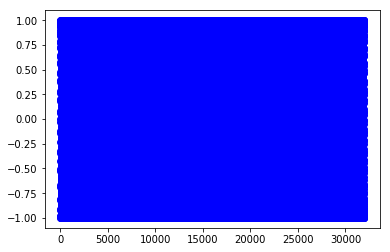

In [85]:
plt.plot(list(range(len(teste))), teste, 'bo')

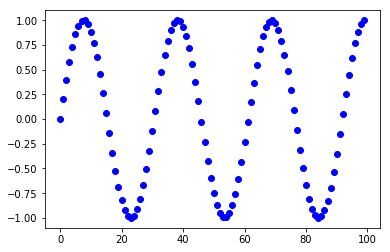

In [86]:
plt.plot(list(range(len(teste[:100]))), teste[:100], 'bo')

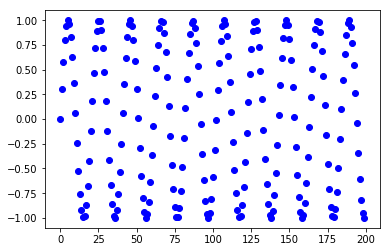

In [87]:
plt.plot(list(range(len(teste[8000:8200]))), teste[8000:8200], 'bo')

### Decompondo os sinais

In [88]:
tempo = 400
#t, x = cria_musica('do,fa,mi,re,do,re,do,do,do,re,do,re,mi,fa', tempo, tempo)
t, x = cria_musica('do,sol,la,do', Fs, tempo)

In [89]:
t

1600

In [90]:
len(x)

1600

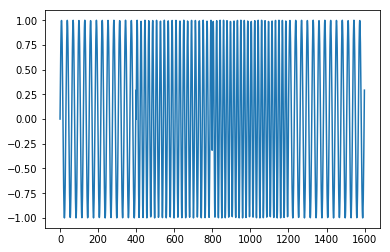

In [91]:
plt.plot(x)

#### 1. Identificando os mínimos e máximos do sinal $x(t)$

In [92]:
from scipy.signal import argrelextrema

In [93]:
def find_extremas(x):
    
    """
    Obtém os máximos e mínimos locais dentre os pontos da função.
    
    :param x: pontos observados da função
    """
    
    # Acha as posições da lista que correspondem aos mínimos e máximos locais
    max_t = argrelextrema(x, np.greater)[0]
    min_t = argrelextrema(x, np.less)[0]
    
    # Acha os valores de máximos e mínimos locais
    max_x = [x[i] for i in max_t]
    min_x = [x[i] for i in min_t]
    
    extremas = [(max_t, min_t), (max_x, min_x)]
    #print(extremas)
    return extremas

In [94]:
x[:10]

array([0.        , 0.20401766, 0.3994532 , 0.57808551, 0.73240031,
       0.85590627, 0.94340802, 0.99122477, 0.99734507, 0.96151146])

In [95]:
extremos = find_extremas(x)

In [96]:
max_t, min_t = extremos[0]
max_x, min_x = extremos[1]

In [97]:
max_t, min_t

(array([   8,   38,   69,   99,  130,  161,  191,  222,  252,  283,  313,
         344,  375,  399,  405,  426,  446,  466,  487,  507,  528,  548,
         568,  589,  609,  630,  650,  670,  691,  711,  732,  752,  772,
         793,  805,  823,  841,  859,  877,  895,  914,  932,  950,  968,
         986, 1005, 1023, 1041, 1059, 1077, 1095, 1114, 1132, 1150, 1168,
        1186, 1208, 1238, 1269, 1299, 1330, 1361, 1391, 1422, 1452, 1483,
        1513, 1544, 1575]),
 array([  23,   54,   84,  115,  145,  176,  206,  237,  268,  298,  329,
         359,  390,  400,  415,  436,  456,  477,  497,  517,  538,  558,
         579,  599,  619,  640,  660,  681,  701,  721,  742,  762,  783,
         799,  814,  832,  850,  868,  886,  905,  923,  941,  959,  977,
         995, 1014, 1032, 1050, 1068, 1086, 1105, 1123, 1141, 1159, 1177,
        1195, 1223, 1254, 1284, 1315, 1345, 1376, 1406, 1437, 1468, 1498,
        1529, 1559, 1590]))

In [98]:
max_x[:10]

[0.9973450676736202,
 0.9989192756429681,
 0.9992166530960727,
 0.996817952017306,
 0.9999802608561371,
 0.9957375858455204,
 0.9996350442301943,
 0.9982563504649323,
 0.9981813860104128,
 0.9996682022499501]

In [99]:
min_x[:10]

[-0.9999129513521229,
 -0.9950763496168068,
 -0.999797877311163,
 -0.9978245414574413,
 -0.9985741811195099,
 -0.9994662992734908,
 -0.9962432196681259,
 -0.9999998026079184,
 -0.9963512569890511,
 -0.9994244598875401]

#### 2. Encontrando os envelope superior e inferior de $x(t)$ passando um spline cúbico através dos máximos e mínimos respectivamente

Utilizando o método [`scipy.interpolate.UnivariateSpline`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.UnivariateSpline.html) para a interpolação de spline cúbica:

In [100]:
from scipy.interpolate import UnivariateSpline

In [101]:
def find_envelopes(x, extremos):

    """
    Obtém os envelopes superior e inferior da função (por uma spline cúbica), e a média.
    
    :param x: pontos da função
    :param extremos: retorno da função find_extremas
    """
    
    max_t, min_t = extremos[0]
    max_x, min_x = extremos[1]
    
    # Obtém o envelope superior
    f_max = UnivariateSpline(max_t, max_x, k=3)
    s_max = f_max(max_t)
    
    # Obtém o envelope inferior
    f_min = UnivariateSpline(min_t, min_x, k=3)
    s_min = f_min(min_t)
    
    # Calcula a média dos envelopes
    t = list(range(len(x)))
    m_t = (f_max(t) + f_min(t))/2
    
    return s_max, s_min, m_t

In [102]:
s_max, s_min, m_t = find_envelopes(x, extremos)

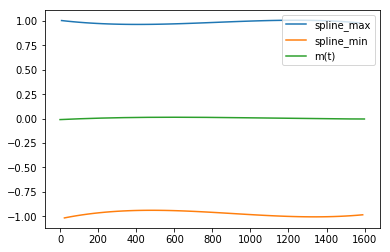

In [103]:
plt.plot(max_t, s_max, label='spline_max')
plt.plot(min_t, s_min, label='spline_min')
plt.plot(m_t, label='m(t)')
plt.legend()

#### 3. Calcule a média dos envelopes superior e inferior como $m(t)$

Calculamos no item anterior, mas aqui demos um zoom:

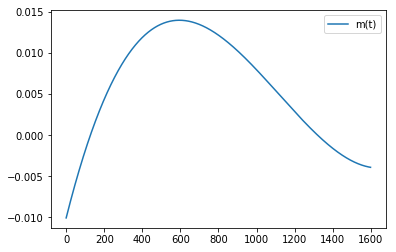

In [104]:
plt.plot(m_t, label='m(t)')
plt.legend()

#### 4. Obter um candidato do FMI usando a fórmula $h_{k}(t) = x(t) - m(t)$

In [105]:
h = x - m_t

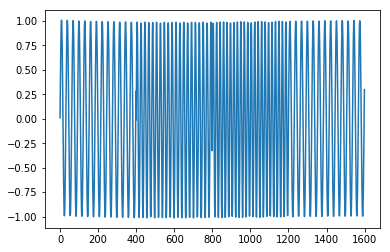

In [106]:
plt.plot(h)

In [107]:
h

array([ 0.01005638,  0.21398213,  0.40932598, ..., -0.10958597,
        0.09550457,  0.29674156])

#### 5. Verifique se as propriedades $h_{k}(t)$ é uma função do modo intrínseco (IMF)

O critério baseia-se no desvio padrão de duas iterações consecutivas, que é definido como $SD$ da seguinte forma:

$$SD_{k}=\sum_{{t=0}}^{{T}}{\frac  {|h_{1(k-1)}(t)-h_{1k}(t)|^{2}}{h_{1(k-1)}^{2}(t)}}$$ 

Vamos afirmar que $h_{k}(t)$ satisfaz as propriedades de uma IMF quando $ SD_{k} < 0.25 $ (limite recomendado por Huang et al. (1998) é entre [0.2, 0.3])

In [203]:
def SD_test(h_list, c=0.25):
    
    """
    Verifica se o desvio padrão satisfaz o critério. 
    
    :param h_list: lista com duas candidatas a IMFs consecutivas
    :param c: limite superior para a soma (entre 0.2 e 0.3)
    """
    
    test = False
          
    # Criamos as duplas de h's para cada t
    h_t = zip(h_list[0], h_list[1])
    
    # Calcula o SD
    SD = sum([(abs(h[1] - h[0])**2)/(h[1]**2) for h in h_t])
    
    # Testa o critério para SD
    if SD < c:
        
        test = True
        
    return SD, test

In [204]:
def sifiting(h):
    
    """
    Faz uma iteração do processo de sifting para h.
    
    :param h: pontos da função candidadta a IMF
    """
    
    # Acha os extremos
    extremos = find_extremas(h)
    
    # Gera as splines e a média dos envelopes
    s_max, s_min, m_t = find_envelopes(x, extremos)
    
    # Gera o próximo candidato a IMF
    h1 = x - m_t
    
    return h1

In [205]:
def imf_test(h, t_max=10000):
    
    """
    Verifica se a função segue as propriedades de uma IMF e faz o processo de sifting até achar uma.
    
    :param h: função h inicial
    :param t_max: número máximo de iterações
    """
    
    h_double = [h] # lista com h_{k-1} e h_{k}
    test = False
    
    # Gera o primeiro sifting
    h_prox = sifiting(h)
    h_double.append(h_prox)
    
    t = 1
    
    # Testa o desvio padrão SD
    SD, result = SD_test(h_double)
    print('>>> Teste {}: \n\n h_(k-1): {}\n h_(k): {}\n SD: {}'.format(t, h_double[0], 
                                                               h_double[1], SD))
    
    while (not result) and (t < t_max):
        
        t +=1
        h_double[0], h_double[1] = h_double[1], sifiting(h_double[0])
        
        SD, result = SD_test(h_double)
        print('>>> Teste {}: \n\n h_(k-1): {}\n h_(k): {}\n SD: {}'.format(t, h_double[0], 
                                                                   h_double[1], SD))
    
    if result:
        
        print('>>> IMF encontrada! \n\n')
        return h_double[1]
        
    else:
        
        print('>>> Número máximo de iterações atingindo. Retornando o último resultado')
        return h_double[1]

In [206]:
c = imf_test(h)

>>> Teste 1: 

 h_(k-1): [ 0.01005638  0.21398213  0.40932598 ... -0.10958597  0.09550457
  0.29674156]
 h_(k): [ 8.88178420e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 1.3911639586089024e+28
>>> Teste 2: 

 h_(k-1): [ 8.88178420e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 h_(k): [ 8.88178420e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 0.0
>>> IMF encontrada! 




In [207]:
c

array([ 8.88178420e-16,  2.04017663e-01,  3.99453203e-01, ...,
       -1.13480667e-01,  9.16058986e-02,  2.92839008e-01])

#### 6. Escolhida a IMF $c_{k} = h^{*}_{k}$, calculamos o resíduo $r_{k}(t) = x(t) - c_{k}$ e testamos o critério de parada: $r_{k}(t)$ deve ser monótona. 

Caso não seja, repetimos o processo tomando $h_{k+1} = r_{k}(t)$

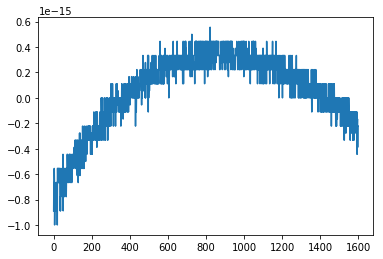

In [208]:
r = x - c

plt.plot(r)

In [265]:
def r_test(r):
    
    """
    Verifica se o resíduo é uma função monótona. 
    A conta não é exata, assumimos que a função é quase certamente monótona
    se até no máximo 13% dos pontos observados têm sinal diferente.
    
    :param r: pontos da função de resíduo
    """
    
    test = False
    r = np.array(r)
    n_max = 0.10*len(r)
    
    # Calculamos as diferenças consecutivas
    r0 = r[:-1]
    r1 = r[1:]
    
    r_diff = r1 - r0
    
    # Removendo os zeros da lista
    r_diff = [x for x in r_diff if x != 0]
    
    # Verifica se é monótona (constante ou crescente/decrescente)
    r_diff = sign(r_diff)
    
    n_pos = len([x for x in r_diff if x == 1])
    n_neg = len([x for x in r_diff if x == -1])
    
    if (n_pos < n_max) or (n_neg < n_max):
        
        test = True
    
    return test, n_pos, n_neg

In [266]:
r_test(r)

(False, 562, 562)

Como $r_1$ não é monótona, devemos voltar ao passo 5 e repetir o processo em 5 e 6, até obtermos $r_k$ monótona.

In [267]:
r

array([-8.88178420e-16, -6.66133815e-16, -8.88178420e-16, ...,
       -3.88578059e-16, -2.22044605e-16, -2.22044605e-16])

In [287]:
def iteration(r, c, t_max=100):
    
    """
    Realiza o processo de iteração até r se tornar monónota.
    
    :param r: pontos da primeria função de resíduo
    :param c: primeira IMF (já calculada)
    """
    
    IMFs = [c]
    print('\n>>> 1a IMF: {}\n'.format(c))
    
    test, n_pos, n_neg = r_test(r)
    
    t = 2
    conv_pos = []
    conv_neg = []
    
    while (not test) and (t < t_max+1):
    
        # Obtém a próxima IMF
        print('\n>>> Calculando a {}a IMF...'.format(t))
        c = imf_test(r)
        IMFs.append(c)
        print('>>> {}a IMF: {}\n'.format(t, c))
        
        # Verifica se r é monótona
        r = x - c
        print(r)
        test, n_pos, n_neg = r_test(r)
        
        conv_pos.append(n_pos)
        conv_neg.append(n_neg)
        print('>>> {}o resíduo: {}'.format(t, r))
        
        t+=1
        
    return IMFs, r, conv_pos, conv_neg

In [288]:
r

array([-8.88178420e-16, -6.66133815e-16, -8.88178420e-16, ...,
       -3.88578059e-16, -2.22044605e-16, -2.22044605e-16])

In [289]:
IMFs, R, n_pos, n_neg = iteration(r, c)


>>> 1a IMF: [ 8.88178420e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]


>>> Calculando a 2a IMF...
>>> Teste 1: 

 h_(k-1): [-8.88178420e-16 -6.66133815e-16 -8.88178420e-16 ... -3.88578059e-16
 -2.22044605e-16 -2.22044605e-16]
 h_(k): [ 7.91012130e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 1622.6561278057372
>>> Teste 2: 

 h_(k-1): [ 7.91012130e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 h_(k): [ 7.91012130e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 0.0
>>> IMF encontrada! 


>>> 2a IMF: [ 7.91012130e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]

[-7.91012130e-16 -7.77156117e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.22044605e-16 -2.22044605e-16]
>>> 2o resíduo: [-7.91012130e-16 -7.77156117e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.22044605e-16 

>>> Teste 1: 

 h_(k-1): [-7.96058610e-16 -8.04911693e-16 -7.77156117e-16 ... -2.35922393e-16
 -2.35922393e-16 -2.22044605e-16]
 h_(k): [ 7.95303234e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 1611.2594068406945
>>> Teste 2: 

 h_(k-1): [ 7.95303234e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 h_(k): [ 7.95303234e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 0.0
>>> IMF encontrada! 


>>> 19a IMF: [ 7.95303234e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]

[-7.95303234e-16 -8.04911693e-16 -7.77156117e-16 ... -2.35922393e-16
 -2.35922393e-16 -2.22044605e-16]
>>> 19o resíduo: [-7.95303234e-16 -8.04911693e-16 -7.77156117e-16 ... -2.35922393e-16
 -2.35922393e-16 -2.22044605e-16]

>>> Calculando a 20a IMF...
>>> Teste 1: 

 h_(k-1): [-7.95303234e-16 -8.04911693e-16 -7.77156117e-16 ... -2.35922393e-16
 -2

>>> Teste 2: 

 h_(k-1): [ 7.93932362e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 h_(k): [ 7.93932362e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 0.0
>>> IMF encontrada! 


>>> 37a IMF: [ 7.93932362e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]

[-7.93932362e-16 -8.04911693e-16 -7.77156117e-16 ... -2.35922393e-16
 -2.35922393e-16 -2.22044605e-16]
>>> 37o resíduo: [-7.93932362e-16 -8.04911693e-16 -7.77156117e-16 ... -2.35922393e-16
 -2.35922393e-16 -2.22044605e-16]

>>> Calculando a 38a IMF...
>>> Teste 1: 

 h_(k-1): [-7.93932362e-16 -8.04911693e-16 -7.77156117e-16 ... -2.35922393e-16
 -2.35922393e-16 -2.22044605e-16]
 h_(k): [ 7.96404018e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 1611.1505533277705
>>> Teste 2: 

 h_(k-1): [ 7.96404018e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9

>>> Teste 1: 

 h_(k-1): [-7.95850618e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.35922393e-16 -2.22044605e-16]
 h_(k): [ 7.96471170e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 1611.183485590399
>>> Teste 2: 

 h_(k-1): [ 7.96471170e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 h_(k): [ 7.96471170e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 0.0
>>> IMF encontrada! 


>>> 56a IMF: [ 7.96471170e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]

[-7.96471170e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.35922393e-16 -2.22044605e-16]
>>> 56o resíduo: [-7.96471170e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.35922393e-16 -2.22044605e-16]

>>> Calculando a 57a IMF...
>>> Teste 1: 

 h_(k-1): [-7.96471170e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.

>>> Teste 2: 

 h_(k-1): [ 7.96367243e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 h_(k): [ 7.96367243e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 0.0
>>> IMF encontrada! 


>>> 67a IMF: [ 7.96367243e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]

[-7.96367243e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.35922393e-16 -2.22044605e-16]
>>> 67o resíduo: [-7.96367243e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.35922393e-16 -2.22044605e-16]

>>> Calculando a 68a IMF...
>>> Teste 1: 

 h_(k-1): [-7.96367243e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.35922393e-16 -2.22044605e-16]
 h_(k): [ 7.95930995e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 1611.1719525848866
>>> Teste 2: 

 h_(k-1): [ 7.95930995e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9

>>> Teste 2: 

 h_(k-1): [ 7.96602592e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 h_(k): [ 7.96602592e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 0.0
>>> IMF encontrada! 


>>> 79a IMF: [ 7.96602592e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]

[-7.96602592e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.35922393e-16 -2.22044605e-16]
>>> 79o resíduo: [-7.96602592e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.35922393e-16 -2.22044605e-16]

>>> Calculando a 80a IMF...
>>> Teste 1: 

 h_(k-1): [-7.96602592e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.35922393e-16 -2.22044605e-16]
 h_(k): [ 7.96650799e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 1611.1863236609756
>>> Teste 2: 

 h_(k-1): [ 7.96650799e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9

>>> Teste 2: 

 h_(k-1): [ 7.96367243e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 h_(k): [ 7.96367243e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 0.0
>>> IMF encontrada! 


>>> 97a IMF: [ 7.96367243e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]

[-7.96367243e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.35922393e-16 -2.22044605e-16]
>>> 97o resíduo: [-7.96367243e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.35922393e-16 -2.22044605e-16]

>>> Calculando a 98a IMF...
>>> Teste 1: 

 h_(k-1): [-7.96367243e-16 -8.04911693e-16 -7.77156117e-16 ... -2.22044605e-16
 -2.35922393e-16 -2.22044605e-16]
 h_(k): [ 7.95930995e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9.16058986e-02  2.92839008e-01]
 SD: 1611.1719525848866
>>> Teste 2: 

 h_(k-1): [ 7.95930995e-16  2.04017663e-01  3.99453203e-01 ... -1.13480667e-01
  9

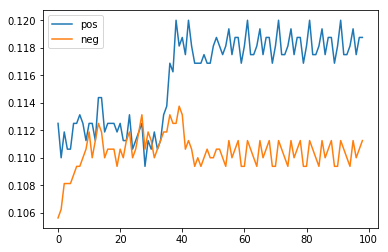

In [290]:
list_pos = list(map(lambda x: x/1600, n_pos))
list_neg = list(map(lambda x: x/1600, n_neg))

plt.plot(list_pos, label='pos')
plt.plot(list_neg, label='neg')
plt.legend()

### Utopia

In [291]:
from pyhht.emd import EMD

decomposer = EMD(x)
imfs = decomposer.decompose()

ImportError: No module named 'pyhht'

In [292]:
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

plot_imfs(x, imfs)

NameError: name 'plot_imfs' is not defined

In [293]:
from pyhht.utils import inst_freq
rcParams['figure.figsize'] = 10, 10

instf, timestamps = inst_freq(x)
plt.plot(timestamps[:100], instf[:100])

ImportError: No module named 'pyhht'